<a href="https://colab.research.google.com/github/edgarbarr1/colon-cancer-cnn/blob/main/colon_cancer_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Colon Cancer Image Classification#
### _Predicting the outcomes of colon cells to predict cancer_ ###

### Business Understanding ###
Colon cancer has been deemed the number 3 most common cancer in the world, according to the World Cancer Research Fund. Based on this statistic, it is not a surprise to know that more approximately 19 million colonoscopies are performed each year in the United States.

Some experts believe that some of the main causes of this cancer is the Western food diet along with living a sedentary lifestyle as well as being obese. Unfortunately, according to the CDC, the US appears to be on an upward trend in obesity which in turn increases the likelihood of men and women to develop colorectal cancers.

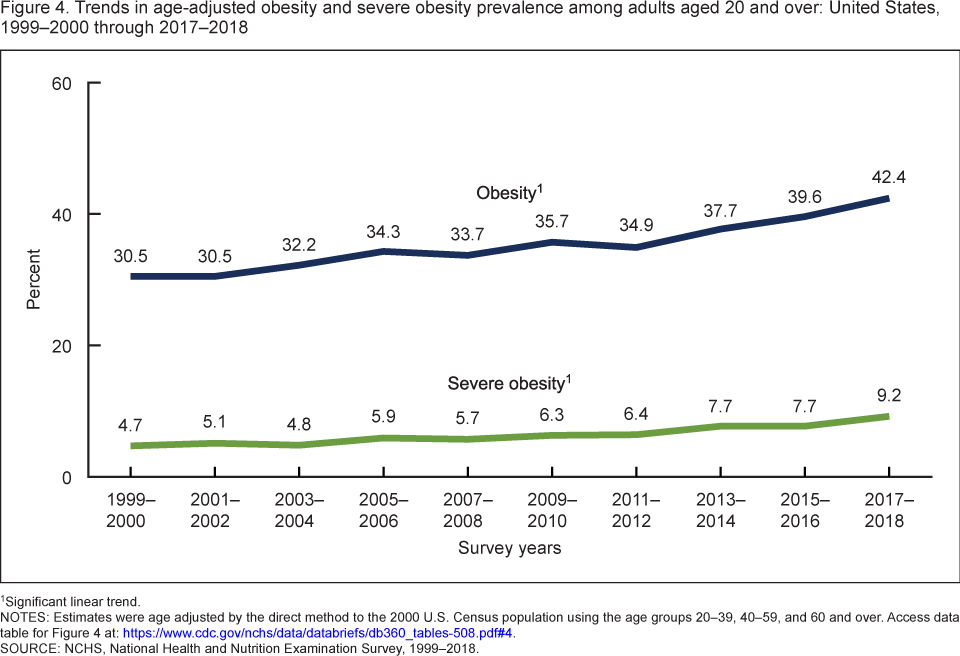


Currently, as per the [American Cancer Society](https://www.cancer.org/treatment/understanding-your-diagnosis/tests/testing-biopsy-and-cytology-specimens-for-cancer/how-long-does-testing-take.html), it takes 2-3 days to report the findings of a colonoscopy biopsy.

## Objective ##
This notebook has the objective of building a Convolutional Neural Network that can get close to the 1-2% error rate with diagnosis that current medical proffesionals. We will also strive to have an efficient model that can give accurate results faster than 2-3 days and ideally within the time frame of "same-day" results.

If these results can be achieved, we could potentially have an additional tool that could be added to the medical field.

## The data ##

The dataset in this notebook comes from a [Zenodo dataset](https://zenodo.org/record/1214456#.YSBSfdNKibt) (cite below).
This dataset contains 100,000 images of 9 different types of colorectal tissue. Each class is divided by a subdirectory. The two classes that we will use in our model is the NORM, for normal colon mucosa and TUM for colorectal adenocarcinoma. This will be the basis of the defined classes for our model. In total there are 14,317 images classified TUM and 8,763 images classified NORM.


Kather, Jakob Nikolas, Halama, Niels, & Marx, Alexander. (2018). 100,000 histological images of human colorectal cancer and healthy tissue (v0.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1214456

### Before Running this Notebook ###

Please make sure to note the following prior to running the notebook:
1. The dataset was downloaded and uploaded to google drive prior to running preprocessing and models
  - In order to run the model smoothly and as is in this notebook, please create a subdirectory in MyDrive named colon_dataset. The dataset `NCT-CRC-HE-100K` will then be added to the newly created subdirectory which contains the NORM and TUM subdirectories we need.
  - Overall our path should look like the following:
    - `/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM or /NORM`
2. Our images are in `TIF` format, a format that is very resource intensive for our model's and can hinder performance, therefore `tif_to_jpeg` function was created. Make sure to run this function to convert our images into jpeg format prior to running our models.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import PIL
import PIL.Image
import pathlib

# Packages to import and preprocess images
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive


# Packages for our models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping



# Model performance
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
import time

%matplotlib inline

In [2]:
drive.mount('/content/drive') # necessary to connect to our images located in drive

Mounted at /content/drive


In [3]:
!wget https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip -P /content/drive/MyDrive/


--2021-09-14 17:29:28--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  6.64MB/s    in 22m 40s 

2021-09-14 17:52:10 (8.20 MB/s) - ‘/content/drive/MyDrive/NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]



In [4]:
!unzip /content/drive/MyDrive/NCT-CRC-HE-100K.zip

Streaming output truncated to the last 5000 lines.
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYVEKTQH.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYPWAIM.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYQVPLI.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYRLNYI.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QADCETNL.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QADWKAWV.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAELGSKC.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAEWQKCK.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAFCMDLW.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAGYSSNM.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAHPWERH.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAIQQTEC.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAISCSQV.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAKWPLCE.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QALEPWFA.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QALGHAQL.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAMFQMMD.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAMICSMH.tif  
  inflating: 

In [5]:
print(tf.__version__) # see the version of tensforflow that we are running

2.6.0


# Standard global variables

We will set some standard global variables that we will use throughout our notebook to try to be as consistent in our experiments.


In [6]:
EPOCHS = 15
BATCH_SIZE = 20
IMAGE_SIZE = (224,224)

# Path to get to our images

paths_to_jpeg = ['/content/NCT-CRC-HE-100K/TUM',
                 '/content/NCT-CRC-HE-100K/NORM']

# Path to divide our images to
separated_dirs = ['/content/colon_dataset/train/normal',
                  '/content/colon_dataset/train/cancer',
                  '/content/colon_dataset/validation/cancer',
                  '/content/colon_dataset/validation/normal',
                  '/content/colon_dataset/test/normal',
                  '/content/colon_dataset/test/cancer']

# Defining our Functions


### Converting images from Tif to Jpeg

In [7]:
def tif_to_jpeg(specified_path):
  '''
  Converts tif images to jpegs from specified path.
  '''
  for path in specified_path:
    for root, dirs, files in os.walk(path, topdown=False,):
      for name in files:
          print(os.path.join(root, name))
          if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            # if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
                print ("A jpeg file already exists for %s" % name)
              # If a jpeg with the name does *NOT* exist, convert one from the tif.
            else:
                  outputfile = os.path.splitext(os.path.join(root, name))[0] + ".jpg"
                  try:
                      im = PIL.Image.open(os.path.join(root, name))
                      print ("Converting jpeg for %s" % name)
                      im.thumbnail(im.size)
                      im.save(outputfile, "JPEG", quality=100)
                  except Exception as e: 
                    print(e)

### Separating our files ###

Inspiration for the function in the creation of the [directories](https://www.youtube.com/watch?v=_L2uYfVV48I)

In [8]:
def file_separation(directory_name):
  '''
  Subdirectory creation and file separation for the training, validation and testing subdirectories.
  '''

  for dir in directory_name:
    if os.path.isdir(dir) is False:
      os.makedirs(dir)

  for image in random.sample(glob.glob('{}/*.jpg'.format(paths_to_jpeg[0])), 8000):
    shutil.move(image, '/content/colon_dataset/train/cancer') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(paths_to_jpeg[1])), 8000):
    shutil.move(image, '/content/colon_dataset/train/normal/') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(paths_to_jpeg[0])), 400):
    shutil.move(image, '/content/colon_dataset/validation/cancer/') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(paths_to_jpeg[1])), 400):
    shutil.move(image, '/content/colon_dataset/validation/normal/') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(paths_to_jpeg[0])), 360):
    shutil.move(image, '/content/colon_dataset/test/cancer') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(paths_to_jpeg[1])), 360):
    shutil.move(image, '/content/colon_dataset/test/normal') # make sure to put the correct path you want it to direct to

### Evaluation Function

In [9]:
def evaluate_model(model, train_gen, val_gen):
  '''
  Returns evaluation metrics for a given Model, training dataset, and validation dataset.
  '''
  train = model.evaluate(train_gen, verbose=1)
  validation = model.evaluate(val_gen, verbose=1)
  return train, validation

### Adding data to our DataFrame

In [10]:
def add_to_DF(df,i,model_name,metrics):
  '''
  Adds model metrics and model name to a specified DataFrame at the Specified index(row).
  '''
  df_data_list = ['loss','precision','recall','accuracy']
  df.at[i, 'model'] = model_name
  
  for x in range(len(df_data_list)):
    df.at[i, df_data_list[x]] = metrics[x]

# Defining Visualization functions

### Confusion Matrix Visualization

In [11]:
def plot_confusion_matrix(y_true, y_pred):
  '''
  returns a confusion matrix plot from the true y values and the predicted y values
  '''
  cm = confusion_matrix(y_true, y_pred,)
  
  ax= plt.subplot()
  # annot=True to annotate cells, fmt='g' to disable scientific notation
  sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='magma', linewidths=1, linecolor='black')

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(['NORMAL', 'CANCER'])
  ax.yaxis.set_ticklabels(['NORMAL', 'CANCER'])
  plt.show();

### Training Visualizations

In [12]:
def visualize_training_results(results):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    results_df = pd.DataFrame(results.history)
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(results_df[results_df.columns[pd.Series(results_df.columns).str.startswith('recall')]])
    ax1.plot(results_df[results_df.columns[pd.Series(results_df.columns).str.startswith('val_recall')]])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(results_df[results_df.columns[pd.Series(results_df.columns).str.startswith('loss')]])
    ax2.plot(results_df[results_df.columns[pd.Series(results_df.columns).str.startswith('val_loss')]])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(results_df[results_df.columns[pd.Series(results_df.columns).str.startswith('precision')]])
    ax3.plot(results_df[results_df.columns[pd.Series(results_df.columns).str.startswith('val_precision')]])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    pass

# Let's convert our images to jpegs

The images in the dataset are in TIF format. Let's convert the images into jpegs. We have fortunately already defined a function to do so.

In [13]:
tif_to_jpeg(paths_to_jpeg)

Streaming output truncated to the last 5000 lines.
/content/NCT-CRC-HE-100K/NORM/NORM-SIPEAQVH.tif
Converting jpeg for NORM-SIPEAQVH.tif
/content/NCT-CRC-HE-100K/NORM/NORM-QTQNKHEQ.tif
Converting jpeg for NORM-QTQNKHEQ.tif
/content/NCT-CRC-HE-100K/NORM/NORM-MEFRLSHA.tif
Converting jpeg for NORM-MEFRLSHA.tif
/content/NCT-CRC-HE-100K/NORM/NORM-WHDPNMMH.tif
Converting jpeg for NORM-WHDPNMMH.tif
/content/NCT-CRC-HE-100K/NORM/NORM-QKYGISKM.tif
Converting jpeg for NORM-QKYGISKM.tif
/content/NCT-CRC-HE-100K/NORM/NORM-HYEQCRTE.tif
Converting jpeg for NORM-HYEQCRTE.tif
/content/NCT-CRC-HE-100K/NORM/NORM-YFGKCQPL.tif
Converting jpeg for NORM-YFGKCQPL.tif
/content/NCT-CRC-HE-100K/NORM/NORM-FIEFCILN.tif
Converting jpeg for NORM-FIEFCILN.tif
/content/NCT-CRC-HE-100K/NORM/NORM-IDTMCKTA.tif
Converting jpeg for NORM-IDTMCKTA.tif
/content/NCT-CRC-HE-100K/NORM/NORM-VVCFDERN.tif
Converting jpeg for NORM-VVCFDERN.tif
/content/NCT-CRC-HE-100K/NORM/NORM-TGINVSMH.tif
Converting jpeg for NORM-TGINVSMH.tif
/co

# Jpegs have been converted. Now separate into subdirectories.

Now let's divide the images into subdirectories.
Currently we have tif and jpeg duplicates in our directory. Now we will move the jpeg images to the newly created directories.

In [14]:
file_separation(separated_dirs)

# Image Data Generator #

Let's create an Image Generator to augment our training data and a separate generator for our validation data.

In [15]:
# Image augmentator for training data
data_gen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = (0.85,1),
    brightness_range = [0.5, 1.0],
    horizontal_flip = True,
    rotation_range = 45
)

# Image Data generator for the validation data
valid_data_gen = ImageDataGenerator(
    rescale = 1./255
)
# Image Data generator for the test/holdout data
test_gen = ImageDataGenerator(
    rescale = 1./255
)

In [16]:
# Generator that creates training data
train_generator = data_gen.flow_from_directory(
    '/content/colon_dataset/train',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    seed = 20
)
# Generator that creates the validation generator
validation_generator = valid_data_gen.flow_from_directory(
    '/content/colon_dataset/validation',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    seed = 20
)
# Evaluation Generator to create predictions and evaluate a model from training data
eval_train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    '/content/colon_dataset/train',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = 'binary',
    seed = 21
)

# Evaluation Generator to create predictions and evaluate a model from validation data
eval_validation_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    '/content/colon_dataset/validation',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = 'binary',
    seed = 21
)
# Evaluation Generator to create predictions and evaluate a model from our holdout/testing data
holdout_data = test_gen.flow_from_directory(
    '/content/colon_dataset/test',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = 'binary',
    seed = 21
)

Found 16000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


Our amount of images checks out based on how many images were ported over to the proper subdirectory.

# DataFrame to Save Model results

We will instantiate a DataFrame to save our model results to and then compare the metrics between the models.

In [ ]:
performance_df = pd.DataFrame()

# Baseline Model

Let's create our first model based on the data generator that we created above.

Our first model will be a rather simple one with the following layers:




1.   A convolutional layer with a (2,2) kernel size or the height and width of our convolutional window.
2.   A Max Pooling Layer that with a height and width of (2,2).
1.   A Dense Layer with a 32 output size
2.   Finally a Dense Layer with a 1 output size and a sigmoid activation function.










In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2,2), activation='relu', padding='same', input_shape = (224,224,3)))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                12845088  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,845,537
Trainable params: 12,845,537
Non-trainable params: 0
_________________________________________________________________


We will be evaluating our model's performance by using Precision, Recall, and Accuracy. Though, we will be paying close attention to `Recall` because we want the highest amount of true positives and false negatives in our results.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), 'accuracy'])

In [ ]:
checkpoint_model_one = ModelCheckpoint('/content/drive/MyDrive/colon_dataset/checkpoint_model_one',
                             monitor='val_loss',
                             verbose = 1,
                             save_best_only=True)

In [ ]:
start = time.time()
history = model.fit(x = train_generator,
                    validation_data = validation_generator,
                    epochs = EPOCHS,
                    steps_per_epoch = 50,
                    callbacks = checkpoint_model_one)
end = time.time()
model_time = end - start # get time it took our model to run/train

Epoch 1/15
50/50 [==============================] - 548s 11s/step - loss: 1.4072 - precision: 0.5077 - recall: 0.5434 - accuracy: 0.5240 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69315, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_one
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_one/assets
Epoch 2/15
50/50 [==============================] - 275s 5s/step - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.4900 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.69315
Epoch 3/15
50/50 [==============================] - 265s 5s/step - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.4930 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5000

Epoch 0000

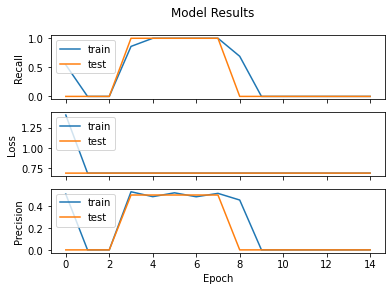

In [ ]:
visualize_training_results(history)

We can see the overtraining of our model in the recall metric towards the end. Let's evaluate with our training data.

In [ ]:
train_model_metrics, val_model_metrics = evaluate_model(model, eval_train_generator, eval_validation_generator)

40/40 [==============================] - 2s 55ms/step - loss: 0.6932 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.5000


It does not appear as though our model learned much from the images, though that is to be expected as it is a very simple model and does not learn much from the images.

Let's save these results.

In [ ]:
performance_df = pd.DataFrame(columns=['model', 'loss', 'precision', 'recall', 'accuracy'])
performance_df.loc[len(performance_df.index)] = ['model_train'] + train_model_metrics
performance_df.loc[len(performance_df.index)] = ['model_valid'] + val_model_metrics
performance_df.head()

,model,loss,precision,recall,accuracy
0,model_train,0.693185,0.0,0.0,0.5
1,model_valid,0.693189,0.0,0.0,0.5


In [ ]:
performance_df['time_to_train'] = model_time

In [ ]:
performance_df.head()

,model,loss,precision,recall,accuracy,time_to_train
0,model_train,0.693185,0.0,0.0,0.5,3228.472164
1,model_valid,0.693189,0.0,0.0,0.5,3228.472164


In [ ]:
training_start = time.time()
preds_train_1 = model.predict(eval_train_generator, verbose=1)
training_end = time.time()

validation_start = time.time()
preds_val_1 = model.predict(eval_validation_generator, verbose = 1)
validation_end = time.time()

training_time = training_end - training_start
validation_time = validation_end - validation_start

40/40 [==============================] - 2s 54ms/step


In [ ]:
performance_df.at[0,'time_to_predict'] = training_time
performance_df.at[1,'time_to_predict'] = validation_time
performance_df

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
0,model_train,0.693185,0.0,0.0,0.5,3228.472164,44.271276
1,model_valid,0.693189,0.0,0.0,0.5,3228.472164,2.278352


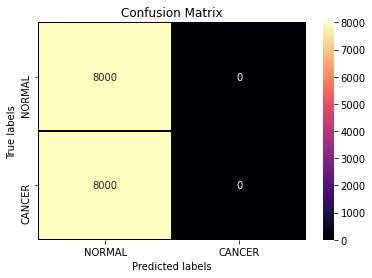

In [ ]:
plot_confusion_matrix(eval_train_generator.labels, np.rint(preds_train_1))

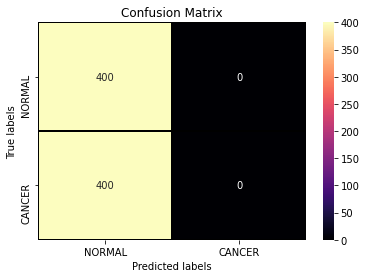

In [ ]:
plot_confusion_matrix(eval_validation_generator.labels, np.rint(preds_val_1))

As per the confusion matrices above, the model seems to be performing well with our NORMAL values. However it is still incorrectly over classifying NORMAL for some of the images. 

The good thing is that this is our first baseline model.

# Model 2 #

We will be adding to our first baseline model by adding more convolutional layers and one more MaxPooling Layer. We will also add one more Dense layer using LeakyReLU as the activation function.

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(2,2), padding='valid', input_shape = (224,224,3)))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, kernel_size=(2,2), padding='same', activation='relu'))
model_2.add(Conv2D(32, kernel_size=(2,2), padding='same', activation='relu'))
model_2.add(MaxPooling2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(128, activation=LeakyReLU(alpha=(.3))))
model_2.add(Dropout(.20))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 32)      416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [ ]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), 'accuracy'])

In [ ]:
checkpoint_model_two = ModelCheckpoint('/content/drive/MyDrive/colon_dataset/checkpoint_model_two',
                             monitor='val_loss',
                             verbose = 1,
                             save_best_only=True)

In [ ]:
start = time.time()
history_2 = model_2.fit(
    x = train_generator,
    validation_data = validation_generator,
    epochs = 15,
    callbacks = checkpoint_model_two
)
end = time.time()

model_2_train_time = end - start

Epoch 1/15
800/800 [==============================] - 210s 261ms/step - loss: 0.5571 - precision_1: 0.6942 - recall_1: 0.7682 - accuracy: 0.7149 - val_loss: 0.5196 - val_precision_1: 0.7990 - val_recall_1: 0.7850 - val_accuracy: 0.7937

Epoch 00001: val_loss improved from inf to 0.51962, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_two


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


Epoch 2/15
800/800 [==============================] - 209s 261ms/step - loss: 0.3523 - precision_1: 0.8303 - recall_1: 0.8649 - accuracy: 0.8441 - val_loss: 0.5045 - val_precision_1: 0.9652 - val_recall_1: 0.6925 - val_accuracy: 0.8338

Epoch 00002: val_loss improved from 0.51962 to 0.50448, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_two


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


Epoch 3/15
800/800 [==============================] - 209s 261ms/step - loss: 0.2944 - precision_1: 0.8695 - recall_1: 0.8941 - accuracy: 0.8799 - val_loss: 0.5642 - val_precision_1: 0.9663 - val_recall_1: 0.7175 - val_accuracy: 0.8462

Epoch 00003: val_loss did not improve from 0.50448
Epoch 4/15
800/800 [==============================] - 208s 260ms/step - loss: 0.2610 - precision_1: 0.8809 - recall_1: 0.9095 - accuracy: 0.8932 - val_loss: 0.9798 - val_precision_1: 0.9886 - val_recall_1: 0.4325 - val_accuracy: 0.7138

Epoch 00004: val_loss did not improve from 0.50448
Epoch 5/15
800/800 [==============================] - 208s 260ms/step - loss: 0.2393 - precision_1: 0.8960 - recall_1: 0.9187 - accuracy: 0.9061 - val_loss: 0.3381 - val_precision_1: 0.9677 - val_recall_1: 0.7500 - val_accuracy: 0.8625

Epoch 00005: val_loss improved from 0.50448 to 0.33814, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_two


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


Epoch 6/15
800/800 [==============================] - 210s 262ms/step - loss: 0.2234 - precision_1: 0.8996 - recall_1: 0.9258 - accuracy: 0.9112 - val_loss: 1.1070 - val_precision_1: 0.9949 - val_recall_1: 0.4875 - val_accuracy: 0.7425

Epoch 00006: val_loss did not improve from 0.33814
Epoch 7/15
800/800 [==============================] - 208s 260ms/step - loss: 0.2127 - precision_1: 0.9046 - recall_1: 0.9304 - accuracy: 0.9161 - val_loss: 0.4781 - val_precision_1: 0.9674 - val_recall_1: 0.7425 - val_accuracy: 0.8587

Epoch 00007: val_loss did not improve from 0.33814
Epoch 8/15
800/800 [==============================] - 208s 260ms/step - loss: 0.2037 - precision_1: 0.9104 - recall_1: 0.9349 - accuracy: 0.9214 - val_loss: 0.5402 - val_precision_1: 0.9750 - val_recall_1: 0.6825 - val_accuracy: 0.8325

Epoch 00008: val_loss did not improve from 0.33814
Epoch 9/15
800/800 [==============================] - 209s 261ms/step - loss: 0.1957 - precision_1: 0.9127 - recall_1: 0.9349 - accuracy

INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_two/assets


Epoch 12/15
800/800 [==============================] - 208s 260ms/step - loss: 0.1811 - precision_1: 0.9202 - recall_1: 0.9415 - accuracy: 0.9299 - val_loss: 0.8842 - val_precision_1: 0.9786 - val_recall_1: 0.5725 - val_accuracy: 0.7800

Epoch 00012: val_loss did not improve from 0.30057
Epoch 13/15
800/800 [==============================] - 208s 259ms/step - loss: 0.1765 - precision_1: 0.9227 - recall_1: 0.9456 - accuracy: 0.9332 - val_loss: 0.5726 - val_precision_1: 0.9720 - val_recall_1: 0.6950 - val_accuracy: 0.8375

Epoch 00013: val_loss did not improve from 0.30057
Epoch 14/15
800/800 [==============================] - 208s 260ms/step - loss: 0.1643 - precision_1: 0.9282 - recall_1: 0.9464 - accuracy: 0.9366 - val_loss: 0.6757 - val_precision_1: 0.9744 - val_recall_1: 0.6650 - val_accuracy: 0.8238

Epoch 00014: val_loss did not improve from 0.30057
Epoch 15/15
800/800 [==============================] - 208s 260ms/step - loss: 0.1648 - precision_1: 0.9274 - recall_1: 0.9473 - accu

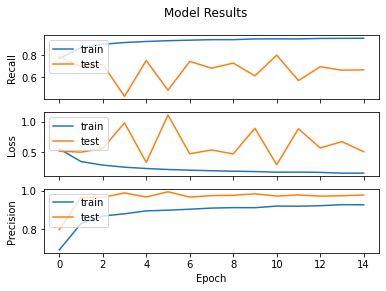

In [ ]:
visualize_training_results(history_2)

We can definitely see an improvement in model performance compared to the base line model. However, we do have some overfitting present in the loss and recall metrics.

In [ ]:
model_metrics_train, model_metrics_val = evaluate_model(model_2, eval_train_generator,eval_validation_generator)

40/40 [==============================] - 2s 55ms/step - loss: 0.5117 - precision_1: 0.9780 - recall_1: 0.6675 - accuracy: 0.8263


In [ ]:
model_two_start_train = time.time()
preds_train_2 = model_2.predict(eval_train_generator)
model_two_end_train = time.time()

model_two_start_val = time.time()
preds_val_2 = model_2.predict(eval_validation_generator)
model_two_end_val = time.time()

model_two_train_time = model_two_end_train - model_two_start_train
model_two_val_time = model_two_end_val - model_two_start_val

Let's add the metrics to our DataFrame.

In [ ]:
add_to_DF(performance_df, 2, 'model_two_train',model_metrics_train)
performance_df.at[2,'time_to_train'] = model_2_train_time
performance_df.at[2,'time_to_predict'] = model_two_train_time

In [ ]:
add_to_DF(performance_df,3,'model_two_val', model_metrics_val)
performance_df.at[3,'time_to_train'] = model_2_train_time
performance_df.at[3,'time_to_predict'] = model_two_val_time

In [ ]:
performance_df

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
0,model_train,0.693185,0.000000,0.00000,0.500000,3228.472164,44.271276
1,model_valid,0.693189,0.000000,0.00000,0.500000,3228.472164,2.278352
2,model_two_train,0.554909,0.976904,0.67675,0.830375,3134.235975,39.830948
3,model_two_val,0.511738,0.978022,0.66750,0.826250,3134.235975,2.067899


It appears that this model took abit less time to train with significantly better results.

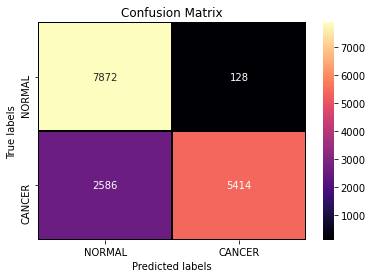

In [ ]:
plot_confusion_matrix(eval_train_generator.labels, np.rint(preds_train_2))

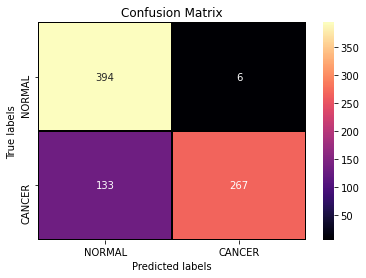

In [ ]:
plot_confusion_matrix(eval_validation_generator.labels, np.rint(preds_val_2))

We can see now, from the matrices depicted above that our validation and training data was predicted, for the most part correctly. We still have 100 images in our validation data and 2212 images incorrectly classified from our predictions.

Let's see if our 3rd model performs any better.

# Model 3 #

Now, we will try to improve preformance on this model by adding 3 more convolutional windows along with a Dropout to prevent the overfitting that we saw present in our second model.

Our Convolutional layers will have a size of 2,2 and 3,3. I decided to keep the convolutional window small as to prevent the loss of details.

In [ ]:
model_3 = Sequential()
model_3.add(Conv2D(32, kernel_size=(2,2), activation='relu',padding='valid', input_shape = (224,224,3)))
model_3.add(Conv2D(32, kernel_size=(2,2), activation='relu', padding='valid'))
model_3.add(Conv2D(64, kernel_size=(2,2), padding='same', activation=LeakyReLU()))
model_3.add(MaxPooling2D(3,3))
model_3.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model_3.add(Conv2D(64, kernel_size=(3,3), padding='same', activation=LeakyReLU()))
model_3.add(MaxPooling2D(2,2))
model_3.add(Conv2D(64, kernel_size=(3,3), activation=LeakyReLU(), padding='valid'))
model_3.add(Flatten())
model_3.add(Dense(64,activation='relu'))
model_3.add(Dense(32, activation=LeakyReLU()))
model_3.add(Dropout(.25))
model_3.add(Dense(32,activation='relu'))
model_3.add(Dense(16, activation=LeakyReLU()))
model_3.add(Dense(1, activation='sigmoid'))

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 32)      416       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 32)      4128      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 64)      8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)       

In [ ]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), 'accuracy'])

In [ ]:
checkpoint_model_three = ModelCheckpoint('/content/drive/MyDrive/colon_dataset/checkpoint_model_three',
                             monitor='val_loss',
                             verbose = 1,
                             save_best_only=True)

In [ ]:
model_three_start = time.time()
history_3 = model_3.fit(x=train_generator,
            validation_data = validation_generator,
            epochs=EPOCHS,
            callbacks = checkpoint_model_three)
model_three_end = time.time()

time_to_train_three = model_three_end - model_three_start

Epoch 1/15
800/800 [==============================] - 215s 265ms/step - loss: 0.5875 - precision_2: 0.6582 - recall_2: 0.6914 - accuracy: 0.6662 - val_loss: 0.6671 - val_precision_2: 0.6286 - val_recall_2: 0.8675 - val_accuracy: 0.6775

Epoch 00001: val_loss improved from inf to 0.66711, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_three


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


Epoch 2/15
800/800 [==============================] - 212s 265ms/step - loss: 0.3885 - precision_2: 0.8112 - recall_2: 0.8643 - accuracy: 0.8316 - val_loss: 0.2978 - val_precision_2: 0.9140 - val_recall_2: 0.7975 - val_accuracy: 0.8612

Epoch 00002: val_loss improved from 0.66711 to 0.29784, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_three


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


Epoch 3/15
800/800 [==============================] - 212s 265ms/step - loss: 0.2610 - precision_2: 0.8878 - recall_2: 0.9134 - accuracy: 0.8990 - val_loss: 0.5906 - val_precision_2: 0.9906 - val_recall_2: 0.5275 - val_accuracy: 0.7613

Epoch 00003: val_loss did not improve from 0.29784
Epoch 4/15
800/800 [==============================] - 211s 264ms/step - loss: 0.1934 - precision_2: 0.9194 - recall_2: 0.9406 - accuracy: 0.9291 - val_loss: 0.2433 - val_precision_2: 0.9706 - val_recall_2: 0.8250 - val_accuracy: 0.9000

Epoch 00004: val_loss improved from 0.29784 to 0.24328, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_three


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


Epoch 5/15
800/800 [==============================] - 214s 267ms/step - loss: 0.1787 - precision_2: 0.9226 - recall_2: 0.9476 - accuracy: 0.9341 - val_loss: 0.3788 - val_precision_2: 0.9562 - val_recall_2: 0.7100 - val_accuracy: 0.8388

Epoch 00005: val_loss did not improve from 0.24328
Epoch 6/15
800/800 [==============================] - 213s 266ms/step - loss: 0.1538 - precision_2: 0.9288 - recall_2: 0.9569 - accuracy: 0.9417 - val_loss: 0.8057 - val_precision_2: 0.9913 - val_recall_2: 0.5700 - val_accuracy: 0.7825

Epoch 00006: val_loss did not improve from 0.24328
Epoch 7/15
800/800 [==============================] - 213s 266ms/step - loss: 0.1401 - precision_2: 0.9344 - recall_2: 0.9607 - accuracy: 0.9466 - val_loss: 0.3430 - val_precision_2: 0.9550 - val_recall_2: 0.7425 - val_accuracy: 0.8537

Epoch 00007: val_loss did not improve from 0.24328
Epoch 8/15
800/800 [==============================] - 213s 266ms/step - loss: 0.1515 - precision_2: 0.9311 - recall_2: 0.9561 - accuracy

INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


Epoch 11/15
800/800 [==============================] - 213s 266ms/step - loss: 0.1222 - precision_2: 0.9485 - recall_2: 0.9653 - accuracy: 0.9564 - val_loss: 0.2438 - val_precision_2: 0.9908 - val_recall_2: 0.8075 - val_accuracy: 0.9000

Epoch 00011: val_loss did not improve from 0.16896
Epoch 12/15
800/800 [==============================] - 212s 265ms/step - loss: 0.1152 - precision_2: 0.9508 - recall_2: 0.9640 - accuracy: 0.9571 - val_loss: 0.1641 - val_precision_2: 0.9891 - val_recall_2: 0.9075 - val_accuracy: 0.9488

Epoch 00012: val_loss improved from 0.16896 to 0.16410, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_model_three


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_model_three/assets


Epoch 13/15
800/800 [==============================] - 213s 266ms/step - loss: 0.1130 - precision_2: 0.9490 - recall_2: 0.9657 - accuracy: 0.9569 - val_loss: 0.3972 - val_precision_2: 0.9659 - val_recall_2: 0.7075 - val_accuracy: 0.8413

Epoch 00013: val_loss did not improve from 0.16410
Epoch 14/15
800/800 [==============================] - 214s 267ms/step - loss: 0.1114 - precision_2: 0.9513 - recall_2: 0.9639 - accuracy: 0.9572 - val_loss: 0.2968 - val_precision_2: 0.9852 - val_recall_2: 0.8325 - val_accuracy: 0.9100

Epoch 00014: val_loss did not improve from 0.16410
Epoch 15/15
800/800 [==============================] - 213s 266ms/step - loss: 0.1105 - precision_2: 0.9477 - recall_2: 0.9715 - accuracy: 0.9589 - val_loss: 0.9140 - val_precision_2: 0.9909 - val_recall_2: 0.5425 - val_accuracy: 0.7688

Epoch 00015: val_loss did not improve from 0.16410


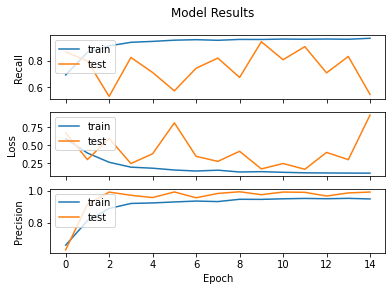

In [ ]:
visualize_training_results(history_3)

Based on the model performance there does not appear to be consistent model performnance. Also based on the loss, the performance appears to be at a standstill.

In [ ]:
train_eval_model, test_eval_model = evaluate_model(model_3, eval_train_generator,eval_validation_generator)

40/40 [==============================] - 2s 57ms/step - loss: 0.9140 - precision_2: 0.9909 - recall_2: 0.5425 - accuracy: 0.7688


In [ ]:
model_three_start_train = time.time()
preds_train_3 = model_3.predict(eval_train_generator)
model_three_end_train = time.time()

model_three_start_val = time.time()
preds_val_3 = model_3.predict(eval_validation_generator)
model_three_end_val = time.time()

model_three_train_time = model_three_end_train - model_three_start_train
model_three_val_time = model_three_end_val - model_three_start_val

In [ ]:
add_to_DF(performance_df,4,'model_three_train',train_eval_model)
performance_df.at[4,'time_to_train'] = time_to_train_three
performance_df.at[4,'time_to_predict'] = model_three_train_time

In [ ]:
add_to_DF(performance_df, 5,'model_three_val',test_eval_model)
performance_df.at[5,'time_to_train'] = time_to_train_three
performance_df.at[5,'time_to_predict'] = model_three_val_time

In [ ]:
performance_df

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
0,model_train,0.693185,0.000000,0.00000,0.500000,3228.472164,44.271276
1,model_valid,0.693189,0.000000,0.00000,0.500000,3228.472164,2.278352
2,model_two_train,0.554909,0.976904,0.67675,0.830375,3134.235975,39.830948
3,model_two_val,0.511738,0.978022,0.66750,0.826250,3134.235975,2.067899
4,model_three_train,0.934448,0.994358,0.52875,0.762875,3201.583020,40.739707
5,model_three_val,0.914030,0.990868,0.54250,0.768750,3201.583020,2.118319


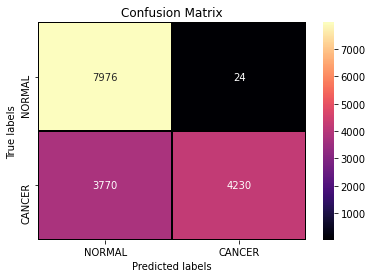

In [ ]:
plot_confusion_matrix(eval_train_generator.labels, np.rint(preds_train_3))

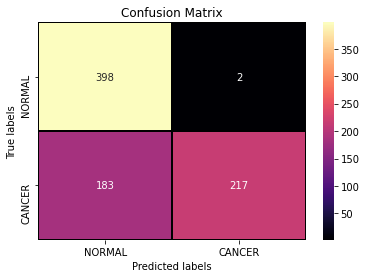

In [ ]:
plot_confusion_matrix(eval_validation_generator.labels, np.rint(preds_val_3))

It appears from the above matrices, that the class that was most correctly classified was the NORMAL, with only 2 images incorrectly classified as CANCER. Unfortunately, the CANCER images were not correctly classfied with only 54% of the images being correctly classified as CANCER.

# ResNet

Seeing as how our models did not perform great, we will turn our attention to transfer learning. For this, we will use [Chi Bui's method](https://github.com/chibui191/pneumonia_detection_resnet50) she implemented on on pulmonary X-ray images.

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
model_4 = Sequential()

resnet_model = ResNet50(weights = 'imagenet',
                        include_top = False,
                        pooling= 'avg')

model_4.add(resnet_model)
model_4.add(Dense(1, activation='sigmoid'))
for layer in resnet_model.layers:
  layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


This item, instead of using `adam` as our optimizer we will use SGD to optimize our learning rate.

In [ ]:
from tensorflow.keras.optimizers import SGD

In [ ]:
sgd = SGD(learning_rate=0.005)
model_4.compile(optimizer=sgd,loss='binary_crossentropy',metrics = [Precision(),Recall(), 'accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_checkpoint = ModelCheckpoint('/content/drive/MyDrive/colon_dataset/checkpoint_resnet',
                             monitor='val_loss',
                             verbose = 1,
                             save_best_only=True)

In [ ]:
class_weight = {0:0.60,
                1:0.40}

In [ ]:
history_resnet = model_4.fit(x = train_generator,
                             validation_data = validation_generator,
                             epochs = EPOCHS,
                             class_weight = class_weight,
                             callbacks = resnet_checkpoint)

Epoch 1/15
800/800 [==============================] - 221s 271ms/step - loss: 0.3325 - precision_3: 0.6301 - recall_3: 0.1420 - accuracy: 0.5293 - val_loss: 0.6487 - val_precision_3: 0.5637 - val_recall_3: 0.8300 - val_accuracy: 0.5938

Epoch 00001: val_loss improved from inf to 0.64867, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
800/800 [==============================] - 217s 271ms/step - loss: 0.3219 - precision_3: 0.7323 - recall_3: 0.2315 - accuracy: 0.5734 - val_loss: 0.6221 - val_precision_3: 0.6568 - val_recall_3: 0.7225 - val_accuracy: 0.6725

Epoch 00002: val_loss improved from 0.64867 to 0.62208, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3169 - precision_3: 0.7256 - recall_3: 0.2826 - accuracy: 0.5879 - val_loss: 0.6109 - val_precision_3: 0.6454 - val_recall_3: 0.7600 - val_accuracy: 0.6712

Epoch 00003: val_loss improved from 0.62208 to 0.61095, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3116 - precision_3: 0.7403 - recall_3: 0.3186 - accuracy: 0.6034 - val_loss: 0.6008 - val_precision_3: 0.6608 - val_recall_3: 0.7550 - val_accuracy: 0.6837

Epoch 00004: val_loss improved from 0.61095 to 0.60080, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3086 - precision_3: 0.7448 - recall_3: 0.3364 - accuracy: 0.6106 - val_loss: 0.5940 - val_precision_3: 0.7798 - val_recall_3: 0.5400 - val_accuracy: 0.6938

Epoch 00005: val_loss improved from 0.60080 to 0.59400, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
800/800 [==============================] - 217s 271ms/step - loss: 0.3079 - precision_3: 0.7435 - recall_3: 0.3450 - accuracy: 0.6130 - val_loss: 0.5869 - val_precision_3: 0.7680 - val_recall_3: 0.6125 - val_accuracy: 0.7138

Epoch 00006: val_loss improved from 0.59400 to 0.58687, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3056 - precision_3: 0.7455 - recall_3: 0.3585 - accuracy: 0.6181 - val_loss: 0.5820 - val_precision_3: 0.7173 - val_recall_3: 0.6725 - val_accuracy: 0.7038

Epoch 00007: val_loss improved from 0.58687 to 0.58202, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3050 - precision_3: 0.7411 - recall_3: 0.3539 - accuracy: 0.6151 - val_loss: 0.5811 - val_precision_3: 0.7462 - val_recall_3: 0.6100 - val_accuracy: 0.7013

Epoch 00008: val_loss improved from 0.58202 to 0.58113, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3031 - precision_3: 0.7369 - recall_3: 0.3711 - accuracy: 0.6193 - val_loss: 0.5804 - val_precision_3: 0.7319 - val_recall_3: 0.6075 - val_accuracy: 0.6925

Epoch 00009: val_loss improved from 0.58113 to 0.58039, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3005 - precision_3: 0.7541 - recall_3: 0.3756 - accuracy: 0.6266 - val_loss: 0.5853 - val_precision_3: 0.7826 - val_recall_3: 0.5400 - val_accuracy: 0.6950

Epoch 00010: val_loss did not improve from 0.58039
Epoch 11/15
800/800 [==============================] - 216s 270ms/step - loss: 0.3009 - precision_3: 0.7499 - recall_3: 0.3730 - accuracy: 0.6243 - val_loss: 0.5797 - val_precision_3: 0.7007 - val_recall_3: 0.7200 - val_accuracy: 0.7063

Epoch 00011: val_loss improved from 0.58039 to 0.57967, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/15
800/800 [==============================] - 216s 270ms/step - loss: 0.2987 - precision_3: 0.7622 - recall_3: 0.3851 - accuracy: 0.6325 - val_loss: 0.5784 - val_precision_3: 0.7300 - val_recall_3: 0.6150 - val_accuracy: 0.6938

Epoch 00012: val_loss improved from 0.57967 to 0.57840, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/15
800/800 [==============================] - 216s 270ms/step - loss: 0.2980 - precision_3: 0.7608 - recall_3: 0.3909 - accuracy: 0.6340 - val_loss: 0.5999 - val_precision_3: 0.7950 - val_recall_3: 0.4750 - val_accuracy: 0.6762

Epoch 00013: val_loss did not improve from 0.57840
Epoch 14/15
800/800 [==============================] - 216s 270ms/step - loss: 0.2972 - precision_3: 0.7619 - recall_3: 0.3968 - accuracy: 0.6364 - val_loss: 0.5789 - val_precision_3: 0.7339 - val_recall_3: 0.6000 - val_accuracy: 0.6913

Epoch 00014: val_loss did not improve from 0.57840
Epoch 15/15
800/800 [==============================] - 216s 269ms/step - loss: 0.2985 - precision_3: 0.7535 - recall_3: 0.3955 - accuracy: 0.6331 - val_loss: 0.5872 - val_precision_3: 0.7711 - val_recall_3: 0.5475 - val_accuracy: 0.6925

Epoch 00015: val_loss did not improve from 0.57840


In [ ]:
for layer in resnet_model.layers:
  layer.trainable = True

In [ ]:
sgd = SGD(learning_rate=0.02)

model_4.compile(optimizer=sgd,
                loss = 'binary_crossentropy',
                metrics = [Precision(), Recall(), 'accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
resnet_start = time.time()
history_resnet_unfrozen = model_4.fit(x = train_generator,
                                      validation_data = validation_generator,
                                      epochs = EPOCHS,
                                      steps_per_epoch = (train_generator.n//20),
                                      validation_steps = (validation_generator.n//20),
                                      callbacks = resnet_checkpoint)
resnet_end = time.time()

resnet_train_time = resnet_end - resnet_start

Epoch 1/15
800/800 [==============================] - 229s 280ms/step - loss: 0.0875 - precision_4: 0.9663 - recall_4: 0.9671 - accuracy: 0.9667 - val_loss: 0.8271 - val_precision_4: 0.6223 - val_recall_4: 0.9925 - val_accuracy: 0.6950

Epoch 00001: val_loss did not improve from 0.57840
Epoch 2/15
800/800 [==============================] - 223s 279ms/step - loss: 0.0361 - precision_4: 0.9868 - recall_4: 0.9868 - accuracy: 0.9868 - val_loss: 0.0212 - val_precision_4: 0.9975 - val_recall_4: 0.9875 - val_accuracy: 0.9925

Epoch 00002: val_loss improved from 0.57840 to 0.02118, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
800/800 [==============================] - 224s 280ms/step - loss: 0.0230 - precision_4: 0.9924 - recall_4: 0.9920 - accuracy: 0.9922 - val_loss: 0.3142 - val_precision_4: 0.8114 - val_recall_4: 1.0000 - val_accuracy: 0.8838

Epoch 00003: val_loss did not improve from 0.02118
Epoch 4/15
800/800 [==============================] - 223s 279ms/step - loss: 0.0200 - precision_4: 0.9930 - recall_4: 0.9924 - accuracy: 0.9927 - val_loss: 0.4912 - val_precision_4: 0.7576 - val_recall_4: 1.0000 - val_accuracy: 0.8400

Epoch 00004: val_loss did not improve from 0.02118
Epoch 5/15
800/800 [==============================] - 223s 279ms/step - loss: 0.0166 - precision_4: 0.9933 - recall_4: 0.9940 - accuracy: 0.9936 - val_loss: 0.0187 - val_precision_4: 0.9950 - val_recall_4: 0.9900 - val_accuracy: 0.9925

Epoch 00005: val_loss improved from 0.02118 to 0.01870, saving model to /content/drive/MyDrive/colon_dataset/checkpoint_resnet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/co

INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
800/800 [==============================] - 225s 281ms/step - loss: 0.0113 - precision_4: 0.9965 - recall_4: 0.9956 - accuracy: 0.9961 - val_loss: 0.0563 - val_precision_4: 0.9704 - val_recall_4: 0.9850 - val_accuracy: 0.9775

Epoch 00006: val_loss did not improve from 0.01870
Epoch 7/15
800/800 [==============================] - 224s 279ms/step - loss: 0.0089 - precision_4: 0.9972 - recall_4: 0.9970 - accuracy: 0.9971 - val_loss: 0.0800 - val_precision_4: 0.9368 - val_recall_4: 1.0000 - val_accuracy: 0.9663

Epoch 00007: val_loss did not improve from 0.01870
Epoch 8/15
800/800 [==============================] - 224s 280ms/step - loss: 0.0080 - precision_4: 0.9974 - recall_4: 0.9973 - accuracy: 0.9973 - val_loss: 0.0376 - val_precision_4: 0.9975 - val_recall_4: 0.9800 - val_accuracy: 0.9887

Epoch 00008: val_loss did not improve from 0.01870
Epoch 9/15
800/800 [==============================] - 224s 280ms/step - loss: 0.0068 - precision_4: 0.9973 - recall_4: 0.9976 - accuracy

INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint_resnet/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/15
800/800 [==============================] - 224s 280ms/step - loss: 0.0064 - precision_4: 0.9981 - recall_4: 0.9973 - accuracy: 0.9977 - val_loss: 0.1647 - val_precision_4: 0.9308 - val_recall_4: 0.9750 - val_accuracy: 0.9513

Epoch 00013: val_loss did not improve from 0.01336
Epoch 14/15
800/800 [==============================] - 224s 279ms/step - loss: 0.0087 - precision_4: 0.9971 - recall_4: 0.9969 - accuracy: 0.9970 - val_loss: 0.1025 - val_precision_4: 0.9433 - val_recall_4: 0.9975 - val_accuracy: 0.9688

Epoch 00014: val_loss did not improve from 0.01336
Epoch 15/15
800/800 [==============================] - 224s 280ms/step - loss: 0.0046 - precision_4: 0.9983 - recall_4: 0.9984 - accuracy: 0.9983 - val_loss: 0.0374 - val_precision_4: 0.9975 - val_recall_4: 0.9825 - val_accuracy: 0.9900

Epoch 00015: val_loss did not improve from 0.01336


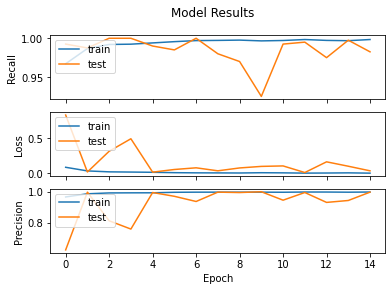

In [ ]:
visualize_training_results(history_resnet_unfrozen)

In [ ]:
resnet_training, resnet_validation = evaluate_model(model_4, eval_train_generator,eval_validation_generator)

40/40 [==============================] - 3s 73ms/step - loss: 0.0374 - precision_4: 0.9975 - recall_4: 0.9825 - accuracy: 0.9900


In [ ]:
resnet_prediction_start = time.time()
preds_train_resnet = model_4.predict(eval_train_generator, verbose=1)
resnet_prediction_end = time.time()

resnet_val_pred_start = time.time()
preds_val_resnet = model_4.predict(eval_validation_generator, verbose=1)
resnet_val_pred_end = time.time()

train_time_resnet = resnet_prediction_end - resnet_prediction_start
val_time_resnet = resnet_val_pred_end - resnet_val_pred_start

40/40 [==============================] - 3s 68ms/step


In [ ]:
add_to_DF(performance_df,6,'model_four_train',resnet_training)
performance_df.at[6,'time_to_train'] = resnet_train_time
performance_df.at[6,'time_to_predict'] = train_time_resnet

In [ ]:
add_to_DF(performance_df, 7, 'model_four_val', resnet_validation)
performance_df.at[7,'time_to_train'] = resnet_train_time
performance_df.at[7,'time_to_predict'] = val_time_resnet

In [ ]:
performance_df.to_csv('/content/drive/MyDrive/colon_dataset/model_performance.csv')

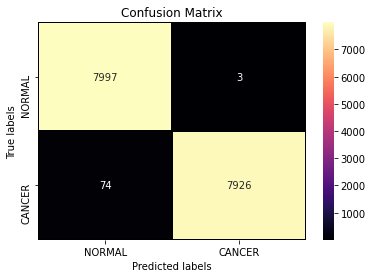

In [ ]:
plot_confusion_matrix(eval_train_generator.labels, np.rint(preds_train_resnet))

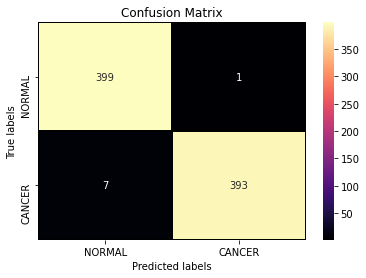

In [ ]:
plot_confusion_matrix(eval_validation_generator.labels, np.rint(preds_val_resnet))

In [ ]:
performance_df.to_csv('model_performance')

# Model Evaluation

With all the saved metrics in our DataFrame, we can now see based on our numbers, what model performed the best.


In [ ]:
performance_df.sort_values(by='recall', ascending=False)

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
6,model_four_train,0.013165,0.999622,0.99075,0.995188,3425.099640,55.228373
7,model_four_val,0.037400,0.997462,0.98250,0.990000,3425.099640,2.870924
2,model_two_train,0.554909,0.976904,0.67675,0.830375,3134.235975,39.830948
3,model_two_val,0.511738,0.978022,0.66750,0.826250,3134.235975,2.067899
5,model_three_val,0.914030,0.990868,0.54250,0.768750,3201.583020,2.118319
4,model_three_train,0.934448,0.994358,0.52875,0.762875,3201.583020,40.739707
0,model_train,0.693185,0.000000,0.00000,0.500000,3228.472164,44.271276
1,model_valid,0.693189,0.000000,0.00000,0.500000,3228.472164,2.278352


It is clear based on the Recall metric that our best performing model was model 4. Not only was the recall metric close to perfect, but the loss was also very low with high precision and accuracy.

In order to fully validate our model results, it is also important to run predictions from data that our model has not "seen". In this case we will use 720 images in our testing subdirectory in an Image Generator named `holdout_data`. This image generator has 360 `NORMAL` images and 360 `CANCER` images.

In [ ]:
testing_predictions = model_4.predict(holdout_data, verbose=1)

36/36 [==============================] - 202s 6s/step


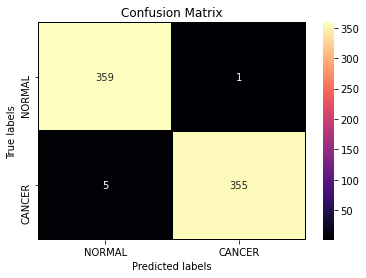

In [ ]:
plot_confusion_matrix(holdout_data.labels, np.rint(testing_predictions))

Great results from the predictions. Out of the 720 images predicted 5 were predicted incorrectly. 

It is also important to point out that more images that weer actually labeled `NORMAL` were predicted as `CANCER`, showing the recall sensitivity was at an acceptable level.

In [ ]:
percentage_incorrect = 6/720
print(percentage_incorrect*100)

0.8333333333333334


Based on the results above, this model predicts correctly with 99.2% accuracy. This would make our model be on par with doctor's determinations when giving a colon cancer diagnosis (1-2% error rate in diagnosis).

# Visualizing Model Explanation

We will install the lime package to visualize what our model is "looking" at to make the determination that a cell image is cancerous or if its a normal cell.

This package was created by marcotcr. See [here for package documentation](https://github.com/marcotcr/lime).

In [ ]:
from keras.preprocessing import image

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path)
        x = image.img_to_array(img)
        x = x/255.
        out.append(x)
    return np.vstack(out)

We will now choose 1 image from each of the subdirectories and from each classes. In total, we should have 6 images to visualize based on the model performance of the Model 4 (our overall best performing model).

In [ ]:
training_img_normal = transform_img_fn([os.path.join(separated_dirs[0],'NORM-AAAKGLVQ.jpg')])
training_img_cancer = transform_img_fn([os.path.join(separated_dirs[1],'TUM-AAALPREY.jpg')])
valid_img_cancer = transform_img_fn([os.path.join(separated_dirs[2],'TUM-AAMGCCCV.jpg')])
valid_img_normal = transform_img_fn([os.path.join(separated_dirs[3],'NORM-AADSPCKQ.jpg')])
holdout_img_normal = transform_img_fn([os.path.join(separated_dirs[4],'NORM-AAQFFIMW.jpg')])
holdout_img_cancer = transform_img_fn([os.path.join(separated_dirs[5], 'TUM-AACWYNKG.jpg')])

We will install `Lime` a package mentioned previously.

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 6.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=7c785487b74d235e3e67510ef9013e368632b0296b80348008463813c47af3ee
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

### First Image

The basis of the model explanation will come from specifying the image we want our model to predict and explain.

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(training_img_normal, model_4.predict, top_labels=5, num_samples=10000,num_features=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

The following will now show the top 10 features that our model "saw". The visualized results below shows the "heaviest" weighted features that caused our model to lean towards predicting towards a particular category.

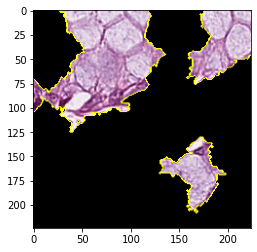

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Now, let's visualize what segmented features were the heaviest which in return caused the `NORMAL` prediction.

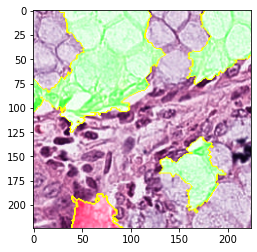

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

As we can see above, the model overall had the correct prediction and overall had its features in the green "pro" category for the NORMAL prediction. There was some slight red towards the bottom most left, however, some more fine tuning of this model should resolve these red areas of concern.

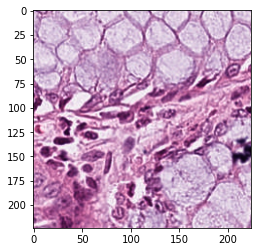

In [ ]:
plt.imshow(training_img_normal)

### Second Image

In [ ]:
explanation = explainer.explain_instance(training_img_cancer, model_4.predict, top_labels=5, num_samples=10000,num_features=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

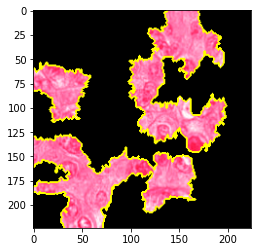

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

This second image was outputted in bright red, or as the package README stated, a con. This just means that the model predicted the alternate category in this case `CANCER`. Since no category was specified for probability explaining, the model automatically chooses the first category as the pro, in this case `NORMAL` and the other category as a con, `CANCER`. Since all of the segmented features in this explanation were con of a `NORMAL` prediction, we can conclude that all these features are in favor of the `CANCER` prediction.

Additionally, we can be sure of this based on the actual classification of this image which comes from the training dataset and has a `CANCER` classification label.

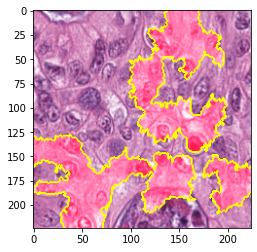

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

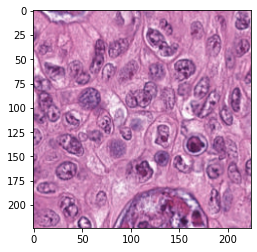

In [ ]:
plt.imshow(training_img_cancer)

### Third Image

In [ ]:
explanation = explainer.explain_instance(valid_img_normal, model_4.predict, top_labels=5, num_samples=10000,num_features=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

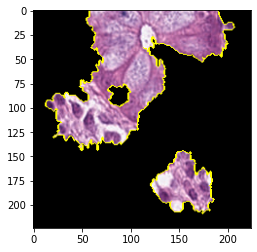

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

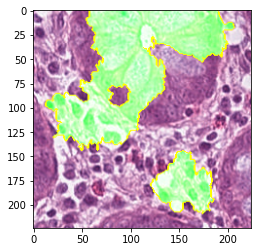

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

We can again see the model predicting in green in pro of the `NORMAL` classification which indeed comes from the validation data with a `NORMAL` label.

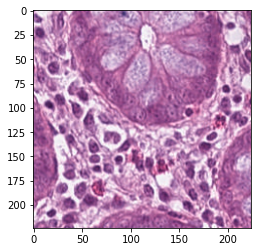

In [ ]:
plt.imshow(valid_img_normal)

### Fourth Image

In [ ]:
explanation = explainer.explain_instance(valid_img_cancer, model_4.predict, top_labels=5, num_samples=10000,num_features=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

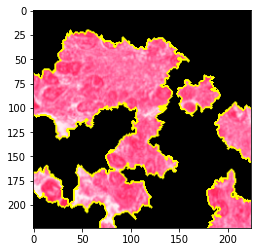

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

This next image comes from the validation folder and has the `CANCER` label. We can see the model explanation is all in red.

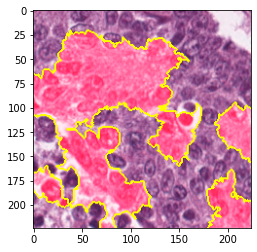

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

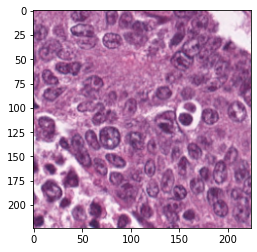

In [ ]:
plt.imshow(valid_img_cancer)

### Fifth Image

In [ ]:
explanation = explainer.explain_instance(holdout_img_normal, model_4.predict, top_labels=5, num_samples=10000,num_features=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

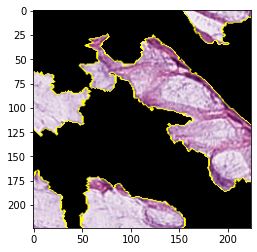

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

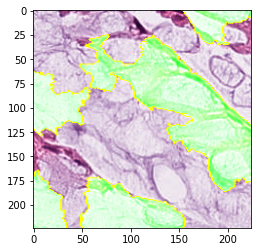

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

This time around our model is all green, in favor of the `NORMAL` classification which indeed is correct. This image comes from the holdout dataset and has the `NORMAL` label.

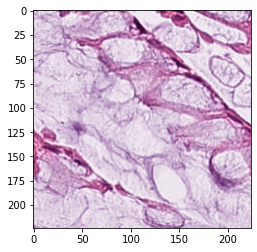

In [ ]:
plt.imshow(holdout_img_normal)

### Sixth Image

In [ ]:
explanation = explainer.explain_instance(holdout_img_cancer, model_4.predict, top_labels=5, num_samples=10000,num_features=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

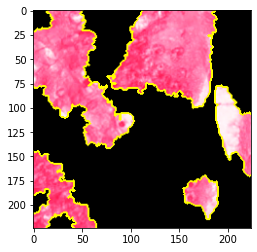

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

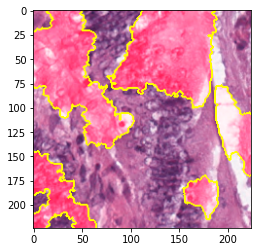

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

We can see our model once again showing us our top 10 features which are once again in all red correctly being categorized as a `CANCER` classified image.

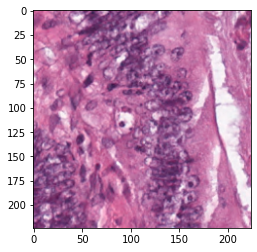

In [ ]:
plt.imshow(holdout_img_cancer)

Overall, based on model explanations, we could see how our model correctly classified our images and for the most part had the correct feature weights in terms of pros and cons.

We had one image where there was slight red but it was not a couse for concern as the model still had a majority of green classifying it as a `NORMAL` cell.

# Conclusion

Based on the restults we have gotten from our model predictions, it is clear that the best model that performed was the ResNet50. 

With its 48 convolutional layers, it was able to learn from the images and correctly classify 99.2% of the images correctly.

The results from the model show the power that Machine Learning can have in a very "convoluted" fiel such as the medical field. Although, it is not expected that Machine Learning Models like this one will take over Doctor's jobs, this shows the incredible potential of becoming an essential tool in the medical field.

One of the potential use cases where this model could be used is in the prioritization of patients based on the model predictions. This would allow the most urgent cases needed for medical evaluation to be quickly given the priority and attention needed.

Another potential use case is the monitored deployment of this model. That is, have a validation team that evaluates the predictions this model outputs and validate or invalidate said prediction. This would not only add a safety net in diagnosis but also allow the continued learning of the model as it keeps being trained with new data.


However, this model is not without its potential risks that we need to take into consideration. For example, it was mentioned in the introduction, that the images in this particular dataset were pre-stained. As someone who has no prior medical experience, I cannot account for the different techniques of staining and different techniques of photographing said stains. The differences in techniques could potentially disrupt the model performance and therefore not give accurate predictions on new images.

# Next Steps

As mentioned above, the key to determine where this model would be the most useful will be with more reserach on the regions that colon cancer is most affecting the population. Additionally, it would be useful to know the distributions and ratios of doctors to patients in particular regions.

Another step worth exploring is the use of different image datasets to use in our models. In this particular dataset, we used a model that had a specific "preprocess" of staining the cells prior to taking the image. It would be worth exploring how a model would perform without cells having gone through that preprocess as the images in this dataset went through. This would most likely save even more time in the diagnosis process since a well trained model would potentially eliminate the step of staining.